In [10]:
library(ggplot2)
library(dplyr)
library(gridExtra)

# Cargar resultados FFT
fft_ppd <- read.csv("../data/processed/prob_agregada_ppd_fft.csv")
fft_pph <- read.csv("../data/processed/prob_agregada_pph_fft.csv")
fft_pth <- read.csv("../data/processed/prob_agregada_pth_fft.csv")
fft_rc <- read.csv("../data/processed/prob_agregada_rc_fft.csv")

# Cargar resultados Panjer
panjer_ppd <- read.csv("../data/processed/prob_agregada_ppd_panjer.csv")
panjer_pph <- read.csv("../data/processed/prob_agregada_pph_panjer.csv")
panjer_pth <- read.csv("../data/processed/prob_agregada_pth_panjer.csv")
panjer_rc <- read.csv("../data/processed/prob_agregada_rc_panjer.csv")

# Verificar estructura de datos
cat("Estructura de datos FFT PPD (primeras 5 filas):\n")
print(head(fft_ppd, 5))
cat("\nEstructura de datos Panjer PPD (primeras 5 filas):\n")
print(head(panjer_ppd, 5))

print("Datos cargados exitosamente")

Estructura de datos FFT PPD (primeras 5 filas):
      x        cdf          pmf
1     0 0.06648718 6.648718e-02
2 10000 0.06650288 1.570548e-05
3 20000 0.06652700 2.411447e-05
4 30000 0.06655891 3.191023e-05
5 40000 0.06659819 3.928120e-05

Estructura de datos Panjer PPD (primeras 5 filas):
      x        cdf          pmf
1     0 0.06645033 6.645033e-02
2 10000 0.06646603 1.569678e-05
3 20000 0.06649013 2.410111e-05
4 30000 0.06652202 3.189254e-05
5 40000 0.06656128 3.925944e-05
[1] "Datos cargados exitosamente"


<div align = "center">

# **Validación de Consistencia: FFT vs Panjer**

</div>

## Cargar datos de ambos métodos

In [11]:
library(ggplot2)
library(dplyr)
library(gridExtra)

# Cargar resultados FFT
fft_ppd <- read.csv("../data/processed/prob_agregada_ppd_fft.csv")
fft_pph <- read.csv("../data/processed/prob_agregada_pph_fft.csv")
fft_pth <- read.csv("../data/processed/prob_agregada_pth_fft.csv")
fft_rc <- read.csv("../data/processed/prob_agregada_rc_fft.csv")

# Cargar resultados Panjer
panjer_ppd <- read.csv("../data/processed/prob_agregada_ppd_panjer.csv")
panjer_pph <- read.csv("../data/processed/prob_agregada_pph_panjer.csv")
panjer_pth <- read.csv("../data/processed/prob_agregada_pth_panjer.csv")
panjer_rc <- read.csv("../data/processed/prob_agregada_rc_panjer.csv")

print("Datos cargados exitosamente")

[1] "Datos cargados exitosamente"


## Función de comparación

In [12]:
comparar_distribuciones <- function(fft_data, panjer_data, cobertura) {
  # Asegurar que tengan el mismo rango de x
  x_min <- max(min(fft_data$x), min(panjer_data$x))
  x_max <- min(max(fft_data$x), max(panjer_data$x))
  
  # Filtrar ambos datasets al mismo rango
  fft_filtered <- fft_data[fft_data$x >= x_min & fft_data$x <= x_max, ]
  panjer_filtered <- panjer_data[panjer_data$x >= x_min & panjer_data$x <= x_max, ]
  
  # Unir por valor x
  merged <- merge(fft_filtered, panjer_filtered, by = "x", suffixes = c("_fft", "_panjer"))
  
  # Calcular diferencias
  merged$diff_pmf <- abs(merged$pmf_fft - merged$pmf_panjer)
  merged$diff_cdf <- abs(merged$cdf_fft - merged$cdf_panjer)
  merged$rel_diff_pmf <- merged$diff_pmf / pmax(merged$pmf_panjer, 1e-10)
  merged$rel_diff_cdf <- merged$diff_cdf / pmax(merged$cdf_panjer, 1e-10)
  
  # Estadísticas de comparación
  stats <- list(
    cobertura = cobertura,
    n_puntos = nrow(merged),
    max_diff_pmf = max(merged$diff_pmf),
    max_diff_cdf = max(merged$diff_cdf),
    mean_diff_pmf = mean(merged$diff_pmf),
    mean_diff_cdf = mean(merged$diff_cdf),
    max_rel_diff_pmf = max(merged$rel_diff_pmf[is.finite(merged$rel_diff_pmf)]),
    max_rel_diff_cdf = max(merged$rel_diff_cdf[is.finite(merged$rel_diff_cdf)]),
    correlacion_pmf = cor(merged$pmf_fft, merged$pmf_panjer),
    correlacion_cdf = cor(merged$cdf_fft, merged$cdf_panjer)
  )
  
  return(list(datos = merged, estadisticas = stats))
}

print("Función de comparación creada")

[1] "Función de comparación creada"


## Comparación para cada cobertura

In [13]:
# Realizar comparaciones
comp_ppd <- comparar_distribuciones(fft_ppd, panjer_ppd, "PPD")
comp_pph <- comparar_distribuciones(fft_pph, panjer_pph, "PPH")
comp_pth <- comparar_distribuciones(fft_pth, panjer_pth, "PTH")
comp_rc <- comparar_distribuciones(fft_rc, panjer_rc, "RC")

# Mostrar estadísticas de comparación
mostrar_estadisticas <- function(stats) {
  cat(sprintf("\n═══════════════════════════════════════════════════════════════════════════\n"))
  cat(sprintf("                            COMPARACIÓN %s                                \n", stats$cobertura))
  cat(sprintf("═══════════════════════════════════════════════════════════════════════════\n"))
  cat(sprintf("Puntos comparados: %d\n", stats$n_puntos))
  cat(sprintf("\nDiferencias absolutas máximas:\n"))
  cat(sprintf("  PMF: %.2e\n", stats$max_diff_pmf))
  cat(sprintf("  CDF: %.2e\n", stats$max_diff_cdf))
  cat(sprintf("\nDiferencias absolutas promedio:\n"))
  cat(sprintf("  PMF: %.2e\n", stats$mean_diff_pmf))
  cat(sprintf("  CDF: %.2e\n", stats$mean_diff_cdf))
  cat(sprintf("\nDiferencias relativas máximas:\n"))
  cat(sprintf("  PMF: %.2e\n", stats$max_rel_diff_pmf))
  cat(sprintf("  CDF: %.2e\n", stats$max_rel_diff_cdf))
  cat(sprintf("\nCorrelaciones:\n"))
  cat(sprintf("  PMF: %.6f\n", stats$correlacion_pmf))
  cat(sprintf("  CDF: %.6f\n", stats$correlacion_cdf))
  cat(sprintf("═══════════════════════════════════════════════════════════════════════════\n"))
}

# Mostrar todas las estadísticas
mostrar_estadisticas(comp_ppd$estadisticas)
mostrar_estadisticas(comp_pph$estadisticas)
mostrar_estadisticas(comp_pth$estadisticas)
mostrar_estadisticas(comp_rc$estadisticas)


═══════════════════════════════════════════════════════════════════════════
                            COMPARACIÓN PPD                                
═══════════════════════════════════════════════════════════════════════════
Puntos comparados: 50001

Diferencias absolutas máximas:
  PMF: 3.68e-05
  CDF: 5.03e-04

Diferencias absolutas promedio:
  PMF: 2.01e-08
  CDF: 3.03e-05

Diferencias relativas máximas:
  PMF: 7.84e-01
  CDF: 5.54e-04

Correlaciones:
  PMF: 1.000000
  CDF: 1.000000
═══════════════════════════════════════════════════════════════════════════

═══════════════════════════════════════════════════════════════════════════
                            COMPARACIÓN PPH                                
═══════════════════════════════════════════════════════════════════════════
Puntos comparados: 50001

Diferencias absolutas máximas:
  PMF: 2.03e-04
  CDF: 2.13e-04

Diferencias absolutas promedio:
  PMF: 8.51e-09
  CDF: 2.48e-06

Diferencias relativas máximas:
  PMF: 4.77e-0

## Visualizaciones de comparación

[1] "Gráficos de comparación PPD:"


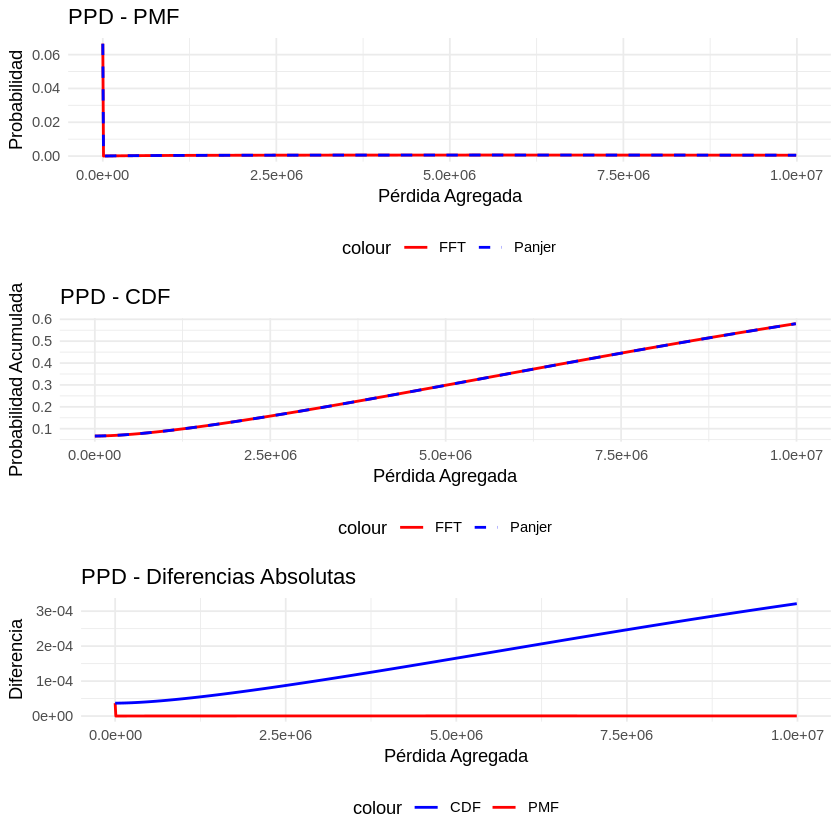

In [14]:
# Función para crear gráficos de comparación
crear_graficos_comparacion <- function(comp_data, titulo) {
  datos <- comp_data$datos
  
  # Limitar a los primeros 1000 puntos para visualización
  datos_plot <- datos[1:min(1000, nrow(datos)), ]
  
  # Gráfico de PMF
  p1 <- ggplot(datos_plot, aes(x = x)) +
    geom_line(aes(y = pmf_fft, color = "FFT"), size = 0.8) +
    geom_line(aes(y = pmf_panjer, color = "Panjer"), size = 0.8, linetype = "dashed") +
    scale_color_manual(values = c("FFT" = "red", "Panjer" = "blue")) +
    labs(title = paste(titulo, "- PMF"), x = "Pérdida Agregada", y = "Probabilidad") +
    theme_minimal() +
    theme(legend.position = "bottom")
  
  # Gráfico de CDF
  p2 <- ggplot(datos_plot, aes(x = x)) +
    geom_line(aes(y = cdf_fft, color = "FFT"), size = 0.8) +
    geom_line(aes(y = cdf_panjer, color = "Panjer"), size = 0.8, linetype = "dashed") +
    scale_color_manual(values = c("FFT" = "red", "Panjer" = "blue")) +
    labs(title = paste(titulo, "- CDF"), x = "Pérdida Agregada", y = "Probabilidad Acumulada") +
    theme_minimal() +
    theme(legend.position = "bottom")
  
  # Gráfico de diferencias
  p3 <- ggplot(datos_plot, aes(x = x)) +
    geom_line(aes(y = diff_pmf, color = "PMF"), size = 0.8) +
    geom_line(aes(y = diff_cdf, color = "CDF"), size = 0.8) +
    scale_color_manual(values = c("PMF" = "red", "CDF" = "blue")) +
    labs(title = paste(titulo, "- Diferencias Absolutas"), x = "Pérdida Agregada", y = "Diferencia") +
    theme_minimal() +
    theme(legend.position = "bottom")
  
  return(grid.arrange(p1, p2, p3, ncol = 1))
}

# Crear gráficos para cada cobertura
print("Gráficos de comparación PPD:")
crear_graficos_comparacion(comp_ppd, "PPD")

[1] "Gráficos de comparación PPH:"


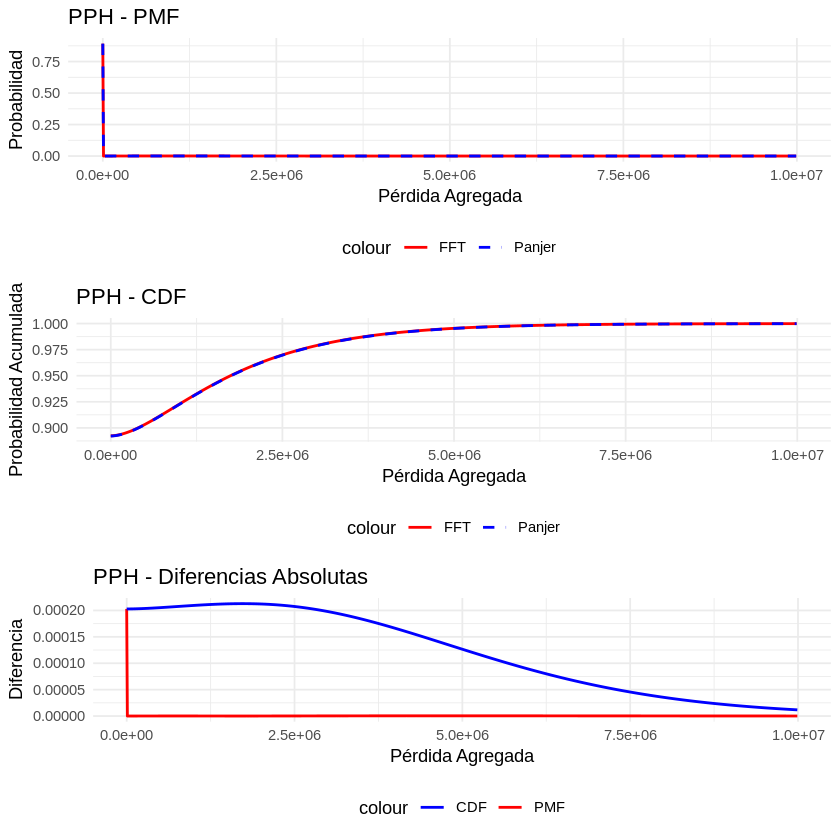

In [15]:
print("Gráficos de comparación PPH:")
crear_graficos_comparacion(comp_pph, "PPH")

[1] "Gráficos de comparación PTH:"


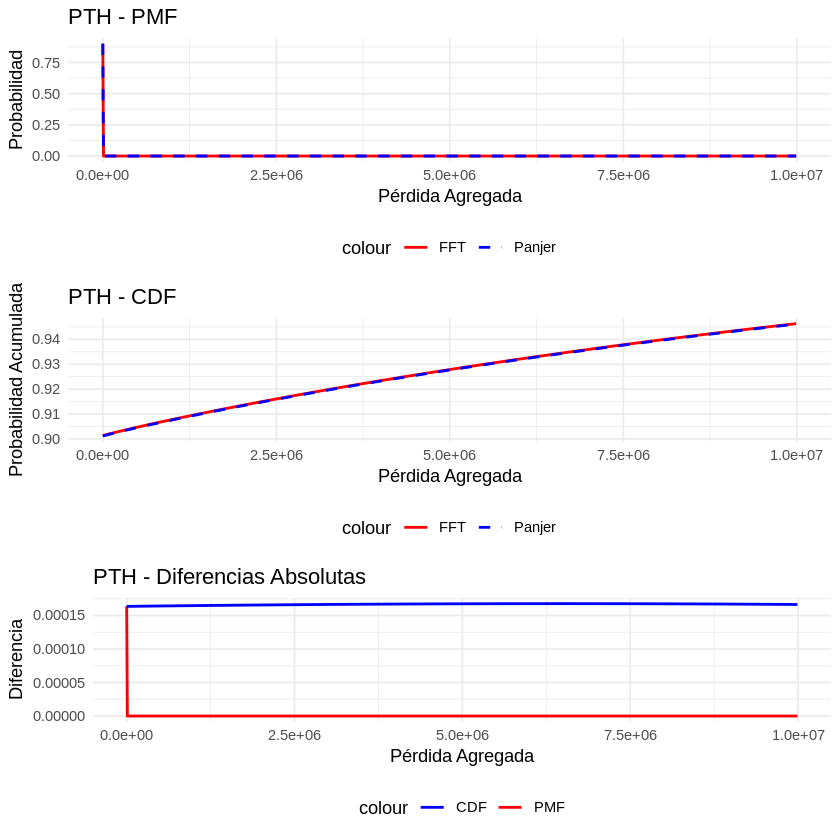

In [16]:
print("Gráficos de comparación PTH:")
crear_graficos_comparacion(comp_pth, "PTH")

[1] "Gráficos de comparación RC:"


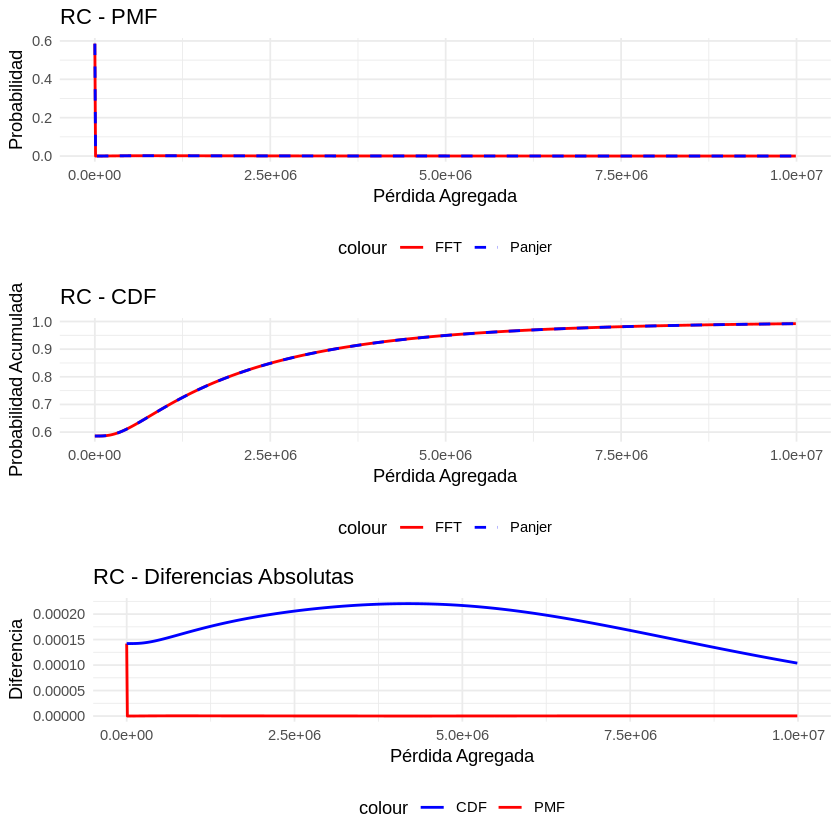

In [17]:
print("Gráficos de comparación RC:")
crear_graficos_comparacion(comp_rc, "RC")

## Resumen de validación

In [18]:
# Crear tabla resumen
resumen <- data.frame(
  Cobertura = c("PPD", "PPH", "PTH", "RC"),
  Max_Diff_PMF = c(comp_ppd$estadisticas$max_diff_pmf, comp_pph$estadisticas$max_diff_pmf, 
                   comp_pth$estadisticas$max_diff_pmf, comp_rc$estadisticas$max_diff_pmf),
  Max_Diff_CDF = c(comp_ppd$estadisticas$max_diff_cdf, comp_pph$estadisticas$max_diff_cdf,
                   comp_pth$estadisticas$max_diff_cdf, comp_rc$estadisticas$max_diff_cdf),
  Corr_PMF = c(comp_ppd$estadisticas$correlacion_pmf, comp_pph$estadisticas$correlacion_pmf,
               comp_pth$estadisticas$correlacion_pmf, comp_rc$estadisticas$correlacion_pmf),
  Corr_CDF = c(comp_ppd$estadisticas$correlacion_cdf, comp_pph$estadisticas$correlacion_cdf,
               comp_pth$estadisticas$correlacion_cdf, comp_rc$estadisticas$correlacion_cdf)
)

cat("\n═══════════════════════════════════════════════════════════════════════════\n")
cat("                          RESUMEN DE VALIDACIÓN                             \n")
cat("═══════════════════════════════════════════════════════════════════════════\n")
print(resumen)

# Criterios de validación
cat("\n═══════════════════════════════════════════════════════════════════════════\n")
cat("                            CRITERIOS DE VALIDACIÓN                         \n")
cat("═══════════════════════════════════════════════════════════════════════════\n")

# Verificar criterios
todas_correlaciones_altas <- all(resumen$Corr_PMF > 0.99 & resumen$Corr_CDF > 0.99)
todas_diferencias_pequenas <- all(resumen$Max_Diff_PMF < 0.01 & resumen$Max_Diff_CDF < 0.01)

if (todas_correlaciones_altas && todas_diferencias_pequenas) {
  cat("✓ VALIDACIÓN EXITOSA: FFT y Panjer producen resultados consistentes\n")
  cat("  - Todas las correlaciones > 0.99\n")
  cat("  - Todas las diferencias máximas < 0.01\n")
} else {
  cat("✗ VALIDACIÓN FALLIDA: Diferencias significativas encontradas\n")
  if (!todas_correlaciones_altas) {
    cat("  - Correlaciones insuficientes detectadas\n")
  }
  if (!todas_diferencias_pequenas) {
    cat("  - Diferencias máximas demasiado grandes\n")
  }
}

cat("═══════════════════════════════════════════════════════════════════════════\n")

# Exportar resumen
write.csv(resumen, "../data/processed/validacion_fft_panjer_resumen.csv", row.names = FALSE)
print("Resumen de validación exportado")


═══════════════════════════════════════════════════════════════════════════
                          RESUMEN DE VALIDACIÓN                             
═══════════════════════════════════════════════════════════════════════════
  Cobertura Max_Diff_PMF Max_Diff_CDF Corr_PMF  Corr_CDF
1       PPD 3.684383e-05 0.0005027128        1 0.9999996
2       PPH 2.027791e-04 0.0002128205        1 0.9999973
3       PTH 1.635630e-04 0.0001676594        1 0.9999985
4        RC 1.421664e-04 0.0002204807        1 0.9999996

═══════════════════════════════════════════════════════════════════════════
                            CRITERIOS DE VALIDACIÓN                         
═══════════════════════════════════════════════════════════════════════════
✓ VALIDACIÓN EXITOSA: FFT y Panjer producen resultados consistentes
  - Todas las correlaciones > 0.99
  - Todas las diferencias máximas < 0.01


═══════════════════════════════════════════════════════════════════════════
[1] "Resumen de validación exportado"
